In [1]:
import json
import copy
import numpy as np
import os
from tqdm import tqdm
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.data import MetadataCatalog, DatasetCatalog
from deepdisc.data_format.image_readers import RomanImageReader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from deepdisc.astrodet.visualizer import ColorMode
from detectron2.structures import BoxMode
from deepdisc.astrodet.visualizer import Visualizer
from astropy.visualization import make_lupton_rgb
import multiprocessing as mp
from functools import partial

/home/yse2/.conda/envs/deepdisc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reader = RomanImageReader()

In [3]:
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test from DatasetCatalog')
    DatasetCatalog.remove("astro_test")

if "astro_test" in MetadataCatalog.list():
    print('removing astro_test from MetadataCatalog')
    MetadataCatalog.remove("astro_test")


red = np.array(colors.to_rgb('red'))*255
white = np.array(colors.to_rgb('white'))*255
blue = np.array(colors.to_rgb('blue'))*255
green = np.array(colors.to_rgb('green'))*255

# DatasetCatalog.register("astro_test", lambda: np.load(testfile))
astrotest_metadata = MetadataCatalog.get("astro_test").set(thing_classes=["galaxy", "star"]).set(thing_colors=[green, red])

In [4]:
def plot_new_anns(ddict, new_img, kind='HWC'):
    # to visualize transformed annotations
    if kind == 'CHW':
        b1 = new_img[2, :, :]
        b2 = new_img[1, :, :]
        b3 = new_img[0, :, :]        
    else:
        b1 = new_img[:, :, 2]
        b2 = new_img[:, :, 1]
        b3 = new_img[:, :, 0]        
    vis_img = make_lupton_rgb(b1, b2, b3, minimum=0, stretch=0.5, Q=10)
    v0 = Visualizer(
        vis_img,
        metadata=astrotest_metadata,
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,
        enable_color_jitter=False# remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=True)# boxf turns off  
    ax1 = plt.subplot(1, 1, 1)
    plt.figure(figsize=(7,7))
    ax1.imshow(groundTruth.get_image())

# For Upsampled LSST: Upsampling Annotations Through ResizeTransform

In [5]:
def transform_annotations(ddict, new_dir, new_dims=(512, 512)):
    """
    Applies a resize transformation to annotation coordinates

    Args:
        ddict (dict): The input dictionary containing metadata and original annotations.
        new_filename (str): The new file_name to assign to the output dictionary.

    Returns:
        dict: A new dictionary with updated annotations and metadata for the new size.
    """
    ddict = copy.deepcopy(ddict) # segmentation masks were causing problems with shallow copy  
    original_h = ddict["height"]
    original_w = ddict["width"]
    new_h, new_w = new_dims  # roman dimension
    resize_transform = T.ResizeTransform(
        original_h, original_w, new_h, new_w, interp=Image.BICUBIC
    )
    annos = [
        utils.transform_instance_annotations(obj, [resize_transform], (new_h, new_w))
        for obj in ddict.pop("annotations")
    ]
    # convert bboxes back to XYWH_ABS and set bbox_mode 
    for ann in annos:
        # Convert the bounding box from XYXY_ABS back to XYWH_ABS format
        bbox = BoxMode.convert(ann["bbox"].tolist(), BoxMode.XYXY_ABS, BoxMode.XYWH_ABS) # convert XYXY_ABS to XYWH_ABS
        ann["bbox"] = bbox
        ann["bbox_mode"] = 1
        # segmentation coords are JSON serializable (lists of floats)
        # transform_instance_annotations already returns polygons as numpy arrays
        ann["segmentation"] = [seg.tolist() for seg in ann['segmentation']]

    ddict["annotations"] = annos
    if original_h > 0 and original_w > 0:
        ddict["height"] = new_h
        ddict["width"] = new_w
    ddict["file_name"] = ddict['file_name'].replace('truth', new_dir)
    ddict["det_cat_path"] = ddict["det_cat_path"].replace("truth", new_dir)
    ddict["truth_cat_path"] = ddict["truth_cat_path"].replace("truth/", new_dir + "/")
    ddict["matched_det_path"] = ddict["matched_det_path"].replace("truth", new_dir)
    return ddict

In [6]:
def process_entry(entry, new_dir):
    new_ddict = transform_annotations(entry, new_dir) # new_dir is truth-ups
    return new_ddict

def process_all_metadata(metadata, new_metadata_file, new_dir):
    num_processes = int(os.environ.get("SLURM_CPUS_ON_NODE", 16))
    pool = mp.Pool(processes=num_processes)
    process_func = partial(process_entry, new_dir=new_dir)
    
    # use imap so we get an iter that tqdm can use
    new_metadata = list(tqdm(
        pool.imap(process_func, metadata),
        total=len(metadata),
        desc="Processing entries"
    ))
    
    pool.close() # close and join to make sure all processes are done and we're back on main
    pool.join()
    
    with open(new_metadata_file, 'w') as output_file:
        json.dump(new_metadata, output_file, indent=4)

## Main Function

In [7]:
root_dir = './lsst_data/'
snr_lvl = 5
anns_dir = os.path.join(root_dir, f'annotations_lvl{snr_lvl}/')
new_anns_dir = os.path.join(root_dir, f'annotations_ups_lvl{snr_lvl}/')
new_truth_dir = 'truth-ups'

os.makedirs(new_anns_dir, exist_ok=True)

for filename in sorted(os.listdir(anns_dir)):
    if filename.endswith('.json'):
        old_path = os.path.join(anns_dir, filename)
        new_path = os.path.join(new_anns_dir, filename)

        with open(old_path, 'r') as f:
            metadata = json.load(f)

        process_all_metadata(metadata, new_path, new_truth_dir)
        print(f"Processed {filename} → saved to {new_path}")

Processing entries: 100%|██████████| 3331/3331 [00:02<00:00, 1252.92it/s]


Processed all_metadata.json → saved to ./lsst_data/annotations_ups_lvl5/all_metadata.json


Processing entries: 100%|██████████| 3600/3600 [00:03<00:00, 1141.75it/s]


Processed all_metadata_incl_empty.json → saved to ./lsst_data/annotations_ups_lvl5/all_metadata_incl_empty.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1337.41it/s]


Processed dc2_50.93_-38.8.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_50.93_-38.8.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 819.52it/s]


Processed dc2_50.93_-42.0.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_50.93_-42.0.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 985.28it/s]


Processed dc2_51.34_-41.3.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_51.34_-41.3.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1329.93it/s]


Processed dc2_51.37_-38.3.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_51.37_-38.3.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 627.95it/s]


Processed dc2_51.53_-40.0.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_51.53_-40.0.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 959.58it/s] 


Processed dc2_52.31_-41.6.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_52.31_-41.6.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 825.16it/s]


Processed dc2_52.40_-41.1.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_52.40_-41.1.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1399.64it/s]


Processed dc2_52.49_-39.1.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_52.49_-39.1.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 565.56it/s]


Processed dc2_52.93_-40.8.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_52.93_-40.8.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1248.23it/s]


Processed dc2_53.25_-41.8.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_53.25_-41.8.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1281.82it/s]


Processed dc2_53.75_-38.9.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_53.75_-38.9.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1945.53it/s]


Processed dc2_54.24_-38.3.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_54.24_-38.3.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 3651.30it/s]


Processed dc2_54.31_-41.6.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_54.31_-41.6.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1519.49it/s]


Processed dc2_55.03_-41.9.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_55.03_-41.9.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 3161.98it/s]


Processed dc2_55.54_-41.9.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_55.54_-41.9.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 966.20it/s]


Processed dc2_56.06_-39.8.json → saved to ./lsst_data/annotations_ups_lvl5/dc2_56.06_-39.8.json


Processing entries: 100%|██████████| 667/667 [00:00<00:00, 1036.72it/s]


Processed test.json → saved to ./lsst_data/annotations_ups_lvl5/test.json


Processing entries: 100%|██████████| 2331/2331 [00:02<00:00, 1123.03it/s]


Processed train.json → saved to ./lsst_data/annotations_ups_lvl5/train.json


Processing entries: 100%|██████████| 333/333 [00:00<00:00, 1092.95it/s]


Processed val.json → saved to ./lsst_data/annotations_ups_lvl5/val.json


## Verifying our Upsampled Annotations

Loaded in ./lsst_data/truth-ups/dc2_52.49_-39.1/full_c111_52.49_-39.1.npy


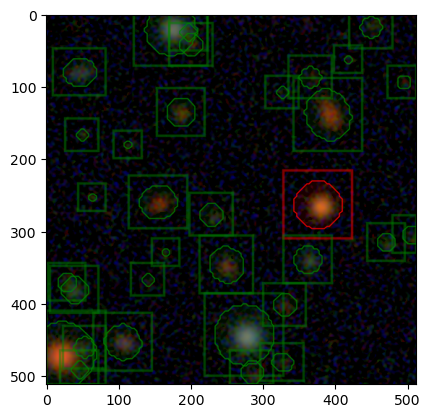

<Figure size 700x700 with 0 Axes>

In [16]:
md_file = f'{new_anns_dir}test.json'
with open(md_file, 'r') as f:
    md = json.load(f)
img = np.load(md[0]['file_name'])
print(f"Loaded in {md[0]['file_name']}")
plot_new_anns(md[0], img, kind='CHW')

# For Upsampled LSST + Roman: Upsampling Annotations Through ResizeTransform

In [7]:
root_dir = './lsst_data/'
snr_lvl = 5
anns_dir = os.path.join(root_dir, f'annotations_lvl{snr_lvl}/')
new_anns_dir = os.path.join(root_dir, f'annotationsc_ups_lvl{snr_lvl}/')
new_truth_dir = 'truthc-ups'

os.makedirs(new_anns_dir, exist_ok=True)

for filename in sorted(os.listdir(anns_dir)):
    if filename.endswith('.json'):
        old_path = os.path.join(anns_dir, filename)
        new_path = os.path.join(new_anns_dir, filename)

        with open(old_path, 'r') as f:
            metadata = json.load(f)

        process_all_metadata(metadata, new_path, new_truth_dir)
        print(f"Processed {filename} → saved to {new_path}")

Processing entries: 100%|██████████| 3331/3331 [00:02<00:00, 1183.88it/s]


Processed all_metadata.json → saved to ./lsst_data/annotationsc_ups_lvl5/all_metadata.json


Processing entries: 100%|██████████| 3600/3600 [00:02<00:00, 1273.62it/s]


Processed all_metadata_incl_empty.json → saved to ./lsst_data/annotationsc_ups_lvl5/all_metadata_incl_empty.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1299.91it/s]


Processed dc2_50.93_-38.8.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_50.93_-38.8.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1479.51it/s]


Processed dc2_50.93_-42.0.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_50.93_-42.0.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1181.74it/s]


Processed dc2_51.34_-41.3.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_51.34_-41.3.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 984.30it/s]


Processed dc2_51.37_-38.3.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_51.37_-38.3.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 805.04it/s]


Processed dc2_51.53_-40.0.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_51.53_-40.0.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 5398.72it/s]


Processed dc2_52.31_-41.6.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_52.31_-41.6.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1193.83it/s]


Processed dc2_52.40_-41.1.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_52.40_-41.1.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 709.99it/s]


Processed dc2_52.49_-39.1.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_52.49_-39.1.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1399.26it/s]


Processed dc2_52.93_-40.8.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_52.93_-40.8.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1460.02it/s]


Processed dc2_53.25_-41.8.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_53.25_-41.8.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 2513.41it/s]


Processed dc2_53.75_-38.9.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_53.75_-38.9.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 2331.49it/s]


Processed dc2_54.24_-38.3.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_54.24_-38.3.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 997.87it/s]


Processed dc2_54.31_-41.6.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_54.31_-41.6.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1239.01it/s]


Processed dc2_55.03_-41.9.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_55.03_-41.9.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 1045.24it/s]


Processed dc2_55.54_-41.9.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_55.54_-41.9.json


Processing entries: 100%|██████████| 225/225 [00:00<00:00, 984.30it/s]


Processed dc2_56.06_-39.8.json → saved to ./lsst_data/annotationsc_ups_lvl5/dc2_56.06_-39.8.json


Processing entries: 100%|██████████| 667/667 [00:00<00:00, 1011.95it/s]


Processed test.json → saved to ./lsst_data/annotationsc_ups_lvl5/test.json


Processing entries: 100%|██████████| 2331/2331 [00:02<00:00, 1126.40it/s]


Processed train.json → saved to ./lsst_data/annotationsc_ups_lvl5/train.json


Processing entries: 100%|██████████| 333/333 [00:00<00:00, 994.68it/s]


Processed val.json → saved to ./lsst_data/annotationsc_ups_lvl5/val.json


Loaded in ./lsst_data/truthc-ups/dc2_52.49_-39.1/full_c111_52.49_-39.1.npy with shape: (10, 512, 512)


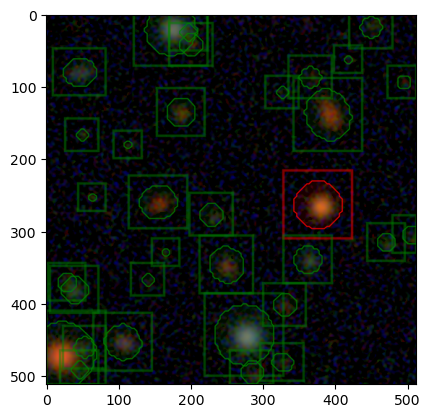

<Figure size 700x700 with 0 Axes>

In [10]:
md_file = f'{new_anns_dir}test.json'
with open(md_file, 'r') as f:
    md = json.load(f)
img = np.load(md[0]['file_name'])
print(f"Loaded in {md[0]['file_name']} with shape: {img.shape}")
plot_new_anns(md[0], img[:,:,:], kind='CHW')